### 📌 전처리 전 데이터로 모델링 실험

#### 1️. 실험 목적
- 기존 모델링에서는 **다중공선성 컬럼 제거 및 이상치 처리**를 적용한 데이터로 학습을 진행함.
- 하지만, **전처리를 적용하기 전의 원본 데이터**로 모델링을 진행했을 때 성능이 어떻게 나오는지 궁금함.
- 따라서 **전처리 전 데이터로 한 번 모델링을 진행**하여 기존과 비교해볼 예정.

---

#### 2️. 실험 내용
- 사용 데이터: **전처리 전의 원본 데이터**
- 비교 대상:
  - ✅ **전처리 후 데이터** (다중공선성 컬럼 제거 + 이상치 처리)
  - ✅ **전처리 전 데이터** (원본 데이터)
- 모델링 기법 및 평가 방법은 기존과 동일하게 진행
  - 랜덤 언더 샘플링으로 진행해볼 예정

---

#### 3. 실험 기대 효과
- 전처리 과정이 모델 성능에 얼마나 영향을 미쳤는지 비교 가능
- 다중공선성 컬럼 처리 및 이상치 제거가 **정말 필요한 과정인지 재검토**할 수 있음


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

전처리 전, 데이터를 불러온 뒤, 2월~9월 데이터를 train 데이터로 생성

In [4]:
df = pd.read_csv("data/full_data/TPS_cancel_data_preprocessing2.csv")

In [8]:
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])]
test = df[df['p_mt'] == 11]

In [9]:
display(train, test)

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,12개월~24개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20240325,733,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,0.0,약정만료전 9~12개월,20240325,764,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,Y,N,60대,수신,수신,6.72,3.33,3.33,JTBC,0.00,N,N,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 9~12개월,20240325,794,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3주일전,N,N,60대,수신,수신,9.86,3.71,3.71,기타,0.00,N,N,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 9~12개월,20240325,825,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,4주일전,N,N,60대,수신,수신,5.95,3.57,3.57,기타,0.00,N,N,5,N
4,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,0.0,약정만료전 6~9개월,20240325,855,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,수신,수신,4.03,6.51,6.51,기타,0.00,N,N,6,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476017,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20200405,2246,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,3.67,1.41,1.41,KBS2,4.00,N,N,5,N
22476018,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20200405,2276,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,3.14,1.35,1.35,KBS1,1.00,N,N,6,N
22476019,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20200405,2307,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,4.10,1.77,1.77,기타,4.00,N,N,7,N
22476020,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20200405,2338,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,2.03,0.01,0.01,KBS1,0.00,N,N,8,N


,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
9,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,재약정,N,0건,0건,I/B,20.0,약정만료전 12개월이상,20260820,1008,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,수신,수신,6.23,4.72,4.72,기타,0.00,N,N,11,N
20,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,24개월~ 36개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,70.0,약정만료전 6~9개월,20240616,4402,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,15.37,0.48,0.48,기타,1.00,N,N,11,N
31,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,일반상담,10.0,약정만료전 12개월이상,20250718,2641,5.00,0.00,5.00,1.00,0.00,Y,N,N,6.00,일주일내,N,N,60대,수신,수신,1.47,2.97,2.97,기타,1.00,N,N,11,N
42,00001c363e8c833646a913c7566acd329523316f6a03afc0fe77dac7ca828d17,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,10.0,약정만료후 9~12개월,20230127,1989,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,N,N,60대,수신,수신,2.16,11.85,11.85,기타,0.00,N,N,11,N
53,00001f885d4d6c5ff6d01d5ebf1d6093d7f53c130de5fa3652dc0424d165b21c,36개월 이상,HD,프리미엄,N,Y,신규,N,1건,1건,현장경로,0.0,약정만료후 12개월이상,20190828,3979,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,N,50대,수신,수신,1.64,2.81,2.81,기타,0.00,N,N,11,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22475979,ffffdac172fec24c59aea00b7c6e53b8f9631e323cb99ada41a5fc7c38eaa74c,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,20191114,3599,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,11,N
22475990,ffffe2ae4b1bafe83133c187e7628932d4915bc7ee92457ac4b1b61e5362c3ba,36개월 이상,HD,이코노미,N,N,신규,N,1건,0건,O/B,10.0,약정만료후 12개월이상,20200831,2281,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,40대,전체거부,전체거부,1.81,4.40,4.40,MBN,0.00,N,N,11,N
22476001,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,12개월~24개월미만,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,0.0,약정만료후 12개월이상,20141014,3958,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,30대,수신,수신,1.69,0.00,0.00,기타,0.00,N,N,11,N
22476012,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.0,약정만료전 12개월이상,20250614,1552,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,3.39,2.42,2.42,기타,0.00,N,N,11,N


In [10]:
display(train['churn'].value_counts(normalize=True) * 100)
display(train['churn'].value_counts())

churn
N   99.31
Y    0.69
Name: proportion, dtype: float64

churn
N    16252767
Y      112678
Name: count, dtype: int64

랜덤 언더 샘플링을 진행하고, LR, RF, XGB, LGBM, Cat 진행

In [12]:
train = train.drop(columns = ['sha2_hash','AGMT_END_YMD','p_mt'])
test = test.drop(columns = ['sha2_hash','AGMT_END_YMD','p_mt'])

In [13]:
from imblearn.under_sampling import RandomUnderSampler

X = train.drop(columns = ['churn'])
y = train['churn']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [14]:
# 원본 데이터 churn 분포!
print("랜덤 언더 샘플링 전:")
print(y.value_counts())

# 랜덤 언더 샘플링 후, churn 분포!
print("\n랜덤 언더 샘플링 후:")
print(pd.Series(y_resampled).value_counts())

랜덤 언더 샘플링 전:
churn
N    16252767
Y      112678
Name: count, dtype: int64

랜덤 언더 샘플링 후:
churn
N    112678
Y    112678
Name: count, dtype: int64


In [15]:
# y_resampled의 이름을 churn으로 명확하게 설정
y_resampled = pd.Series(y_resampled, name='churn')

# 그리고 X_resampled와 y_resampled 병합
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

([<matplotlib.axis.XTick at 0x1d5000c0310>,
 [Text(0.0, 0, 'N'), Text(1.0, 0, 'Y')])

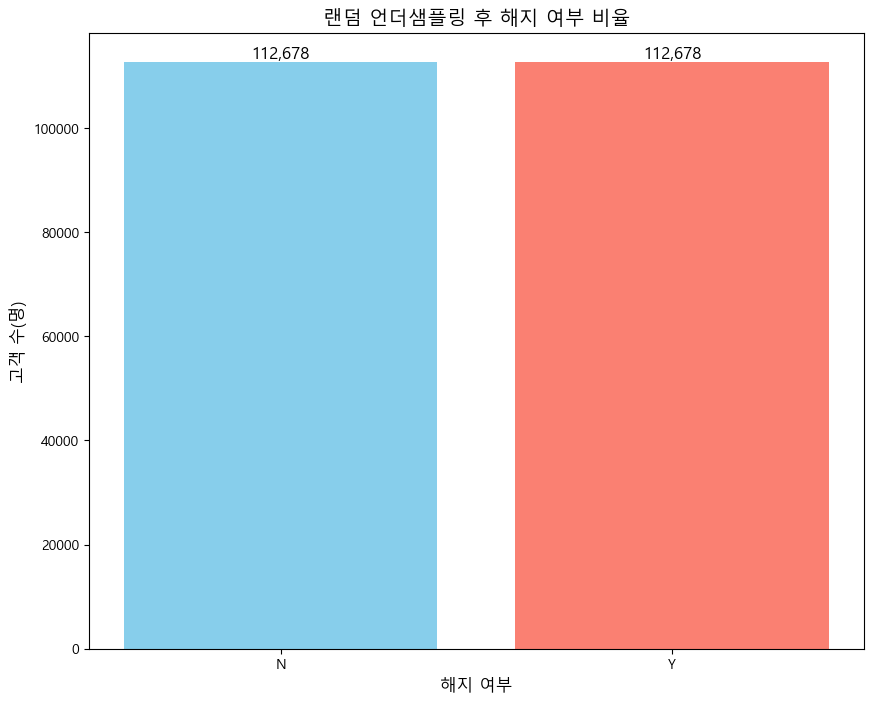

In [16]:
import matplotlib.pyplot as plt

churn_counts = resampled_data['churn'].value_counts()

plt.figure(figsize=(10, 8))
bars = plt.bar(churn_counts.index, churn_counts.values, color=['skyblue', 'salmon'])

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{bar.get_height():,}', ha='center', va='bottom', fontsize=12)

plt.xlabel('해지 여부', fontsize=12)
plt.ylabel('고객 수(명)', fontsize=12)
plt.title('랜덤 언더샘플링 후 해지 여부 비율', fontsize=14)
plt.xticks(churn_counts.index, labels=[str(i) for i in churn_counts.index])

In [17]:
train = resampled_data

### 로지스틱 회귀 진행

In [19]:
display(train)
display(test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn
16059968,12개월~24개월미만,HD,스탠다드,N,N,재약정,N,0건,0건,일반상담,10.0,약정만료전 12개월이상,3307,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,70대,전체거부,수신,2.59,0.18,0.18,기타,0.00,N,N,N
20340198,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,20.0,약정만료후 12개월이상,2444,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,6.55,0.68,0.68,기타,1.00,N,N,N
17965298,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,1건,현장경로,30.0,약정만료전 1개월,1085,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,전체거부,전체거부,3.85,1.06,1.06,기타,0.00,N,N,N
17018470,36개월 이상,HD,이코노미,N,N,약정승계,Y,0건,0건,일반상담,알수없음,약정만료후 12개월이상,2720,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,N
11443577,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,20.0,약정만료전 12개월이상,2366,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,Y,N,60대,전체거부,전체거부,1.98,5.80,5.80,기타,0.00,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474906,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,일반상담,0.0,약정만료전 12개월이상,3712,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,60대,수신,수신,1.90,0.26,0.26,tvN,0.00,N,N,Y
22475066,12개월~24개월미만,HD,이코노미,N,N,신규,Y,0건,0건,O/B,알수없음,약정만료전 12개월이상,501,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,Y
22475552,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,11,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,전체거부,전체거부,3.49,0.65,0.65,기타,0.00,Y,Y,Y
22475741,6개월~12개월미만,HD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,231,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,50대,전체거부,전체거부,0.62,0.00,0.00,기타,0.00,N,N,Y


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn
9,24개월~ 36개월미만,HD,이코노미,N,Y,재약정,N,0건,0건,I/B,20.0,약정만료전 12개월이상,1008,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,수신,수신,6.23,4.72,4.72,기타,0.00,N,N,N
20,24개월~ 36개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,70.0,약정만료전 6~9개월,4402,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,15.37,0.48,0.48,기타,1.00,N,N,N
31,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,일반상담,10.0,약정만료전 12개월이상,2641,5.00,0.00,5.00,1.00,0.00,Y,N,N,6.00,일주일내,N,N,60대,수신,수신,1.47,2.97,2.97,기타,1.00,N,N,N
42,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,10.0,약정만료후 9~12개월,1989,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,N,N,60대,수신,수신,2.16,11.85,11.85,기타,0.00,N,N,N
53,36개월 이상,HD,프리미엄,N,Y,신규,N,1건,1건,현장경로,0.0,약정만료후 12개월이상,3979,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,N,50대,수신,수신,1.64,2.81,2.81,기타,0.00,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22475979,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,3599,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,N
22475990,36개월 이상,HD,이코노미,N,N,신규,N,1건,0건,O/B,10.0,약정만료후 12개월이상,2281,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,40대,전체거부,전체거부,1.81,4.40,4.40,MBN,0.00,N,N,N
22476001,12개월~24개월미만,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,0.0,약정만료후 12개월이상,3958,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,30대,수신,수신,1.69,0.00,0.00,기타,0.00,N,N,N
22476012,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.0,약정만료전 12개월이상,1552,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,3.39,2.42,2.42,기타,0.00,N,N,N


레이블 인코딩 진행

In [22]:
from sklearn.preprocessing import LabelEncoder

train_and_test = pd.concat([train, test])

categorical_cols = train_and_test.select_dtypes(include=['object']).columns

label_encoders = {}

for col in categorical_cols:
  le = LabelEncoder()
  train_and_test[col] = le.fit_transform(train_and_test[col])
  label_encoders[col] = le

# 인코딩 후, 다시 train과 test로 분리

train = train_and_test.iloc[:len(train)].reset_index(drop=True)
test = train_and_test.iloc[len(train):].reset_index(drop=True)

print("레이블 인코딩 끝! 😁")

레이블 인코딩 끝! 😁


In [23]:
for col, le in label_encoders.items():
    print(f"🔹 {col} 레이블 인코딩 매핑")
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(label_mapping)
    print("-" * 30)

🔹 SVC_USE_DAYS_GRP 레이블 인코딩 매핑
{'12개월~24개월미만': 0, '24개월~ 36개월미만': 1, '36개월 이상': 2, '6개월~12개월미만': 3, '6개월미만': 4}
------------------------------
🔹 MEDIA_NM_GRP 레이블 인코딩 매핑
{'HD': 0, 'UHD': 1, '기타': 2}
------------------------------
🔹 PROD_NM_GRP 레이블 인코딩 매핑
{'기타': 0, '베이직': 1, '세이버': 2, '스탠다드': 3, '이코노미': 4, '프리미엄': 5}
------------------------------
🔹 PROD_OLD_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 PROD_ONE_PLUS_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 AGMT_KIND_NM 레이블 인코딩 매핑
{'신규': 0, '약정갱신': 1, '약정승계': 2, '약정연장': 3, '약정축소': 4, '재약정': 5, '정보없음': 6}
------------------------------
🔹 STB_RES_1M_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 SVOD_SCRB_CNT_GRP 레이블 인코딩 매핑
{'0건': 0, '1건': 1, '2건': 2, '3건 이상': 3}
------------------------------
🔹 PAID_CHNL_CNT_GRP 레이블 인코딩 매핑
{'0건': 0, '1건': 1, '2건': 2, '3건 이상': 3}
------------------------------
🔹 SCRB_PATH_NM_GRP 레이블 인코딩 매핑
{'I/B': 0, 'O/B': 1, '기타': 2, '렌탈제휴': 3, '일반상담': 4, '임직원': 5,

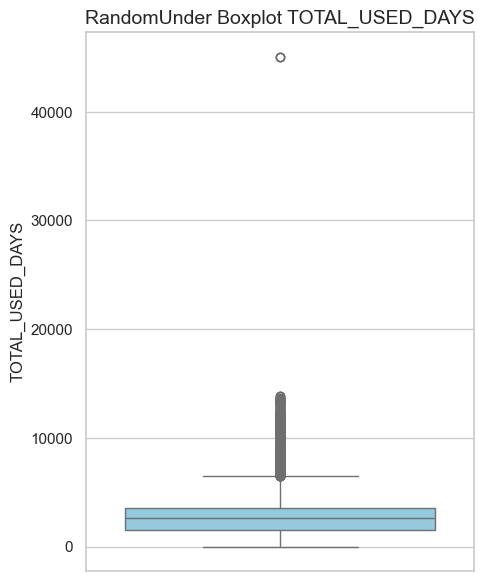

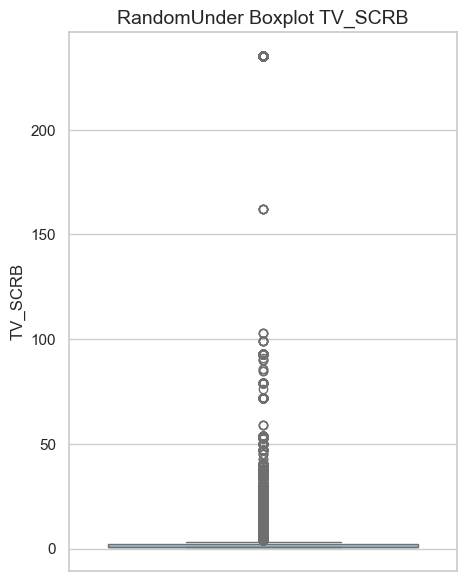

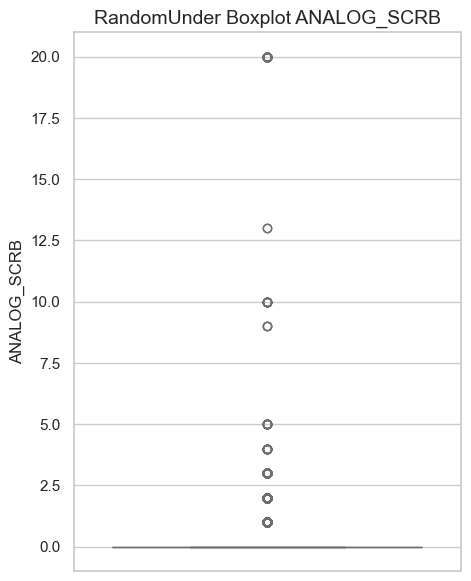

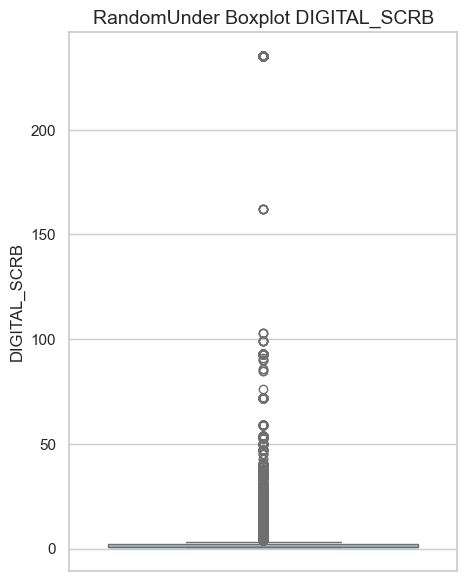

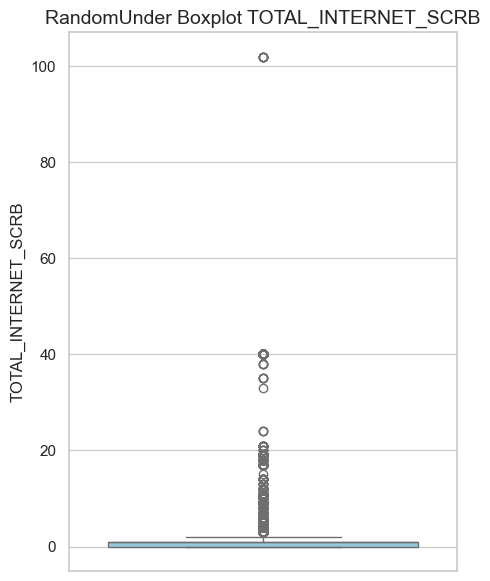

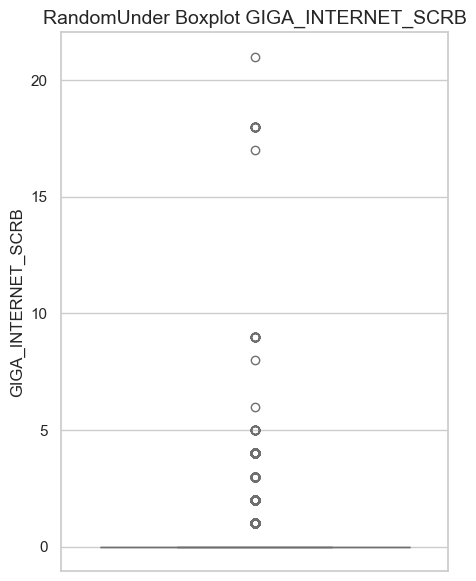

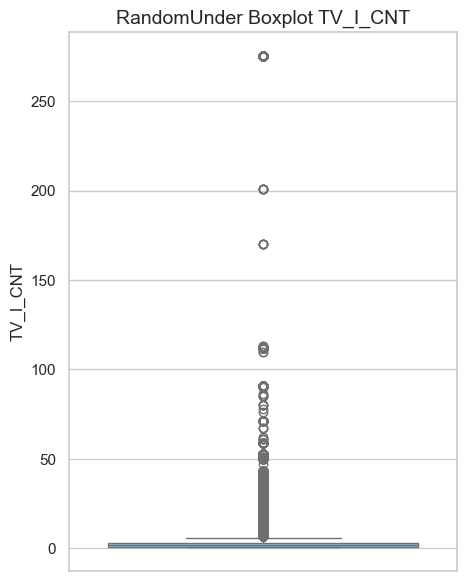

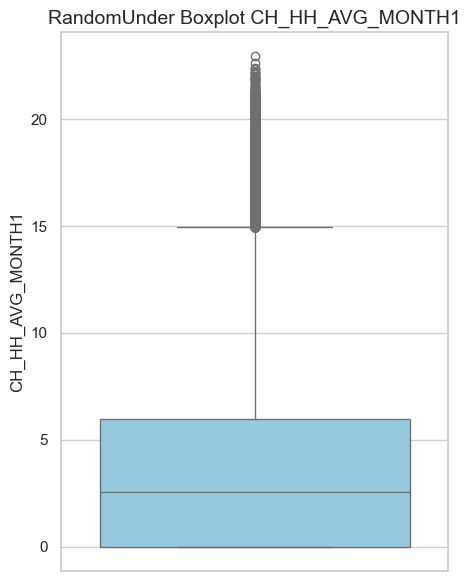

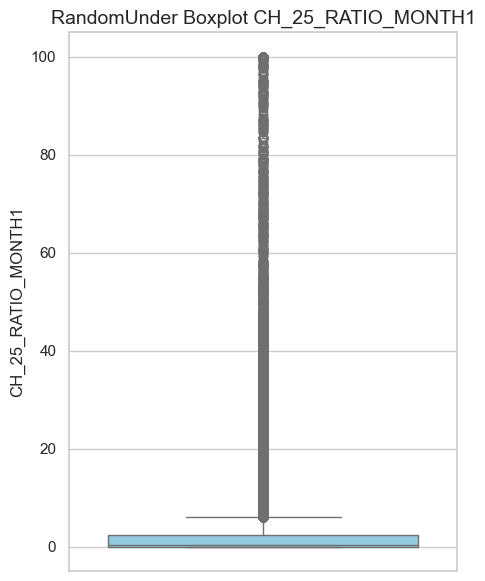

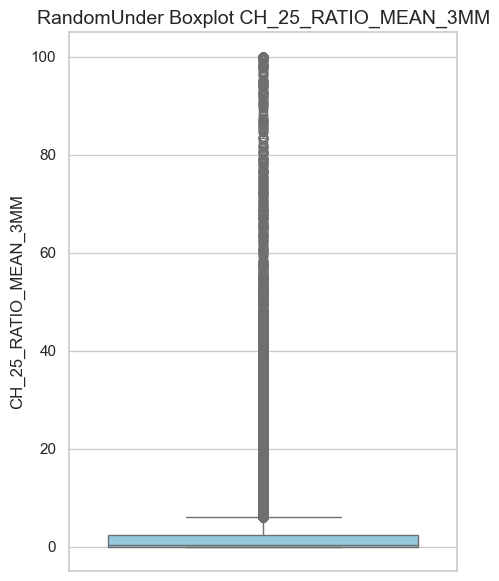

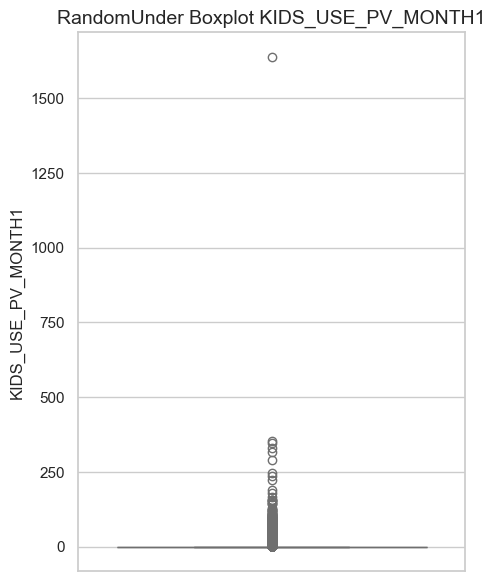

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# df에서 연속형(수치형) 변수 찾기
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

sns.set(style="whitegrid")

# 각 연속형 변수에 대해 boxplot
for col in numeric_columns:
    plt.figure(figsize=(5, 7))
    sns.boxplot(y=train[col], color="skyblue")

    plt.ylabel(col, fontsize=12)
    plt.title(f'RandomUnder Boxplot {col}', fontsize=14)

    plt.show()


In [26]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# boxplot으로 확인한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS','TV_SCRB','CH_HH_AVG_MONTH1','KIDS_USE_PV_MONTH1','CH_25_RATIO_MONTH1','ANALOG_SCRB','DIGITAL_SCRB','TOTAL_INTERNET_SCRB','CH_25_RATIO_MEAN_3MM','TV_I_CNT','GIGA_INTERNET_SCRB']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [27]:
display(train, test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn
0,0.00,0.00,0.50,0.00,0.00,0.83,0.00,0.00,0.00,0.44,0.09,0.08,0.34,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.50,0.80,0.00,0.00,0.67,1.00,0.67,0.01,-0.05,-0.05,0.92,0.00,0.00,0.00,0
1,0.50,0.00,0.00,0.00,0.00,0.83,0.00,0.00,0.00,1.00,0.27,0.62,-0.10,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.80,0.00,0.00,0.67,0.67,0.67,0.67,0.15,0.15,0.92,1.00,0.00,0.00,0
2,0.75,0.50,0.00,0.00,0.00,0.33,0.00,0.00,0.33,1.00,0.36,0.23,-0.79,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.50,0.80,0.00,0.00,0.44,1.00,1.00,0.22,0.31,0.31,0.92,0.00,0.00,0.00,0
3,0.50,0.00,0.75,0.00,0.00,0.33,1.00,0.00,0.00,0.44,1.00,0.62,0.04,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,-0.50,0.20,0.00,0.00,0.78,0.67,0.67,-0.43,-0.13,-0.13,0.92,0.00,0.00,0.00,0
4,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.27,0.08,-0.14,2.00,0.00,2.00,-1.00,0.00,0.00,0.00,0.00,0.50,0.80,1.00,0.00,0.56,1.00,1.00,-0.09,2.25,2.26,0.92,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225351,0.50,0.00,1.00,0.00,0.00,0.83,1.00,0.00,0.00,0.44,0.00,0.08,0.54,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.80,0.00,0.00,0.56,0.67,0.67,-0.11,-0.02,-0.02,0.85,0.00,0.00,0.00,1
225352,0.00,0.00,0.75,0.00,0.00,0.00,1.00,0.00,0.00,0.11,1.00,0.08,-1.08,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.20,0.00,0.00,0.22,0.67,0.67,-0.43,-0.13,-0.13,0.92,0.00,0.00,0.00,1
225353,1.00,0.50,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.08,-1.33,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.80,1.00,0.00,0.44,1.00,1.00,0.16,0.14,0.14,0.92,0.00,1.00,1.00,1
225354,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.08,-1.22,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,-0.50,1.00,0.00,0.00,0.44,1.00,1.00,-0.32,-0.13,-0.13,0.92,0.00,0.00,0.00,1


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn
0,0.25,0.00,0.75,0.00,1.00,0.83,0.00,0.00,0.00,0.00,0.27,0.08,-0.83,1.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.50,0.80,0.00,0.00,0.56,0.67,0.67,0.62,1.81,1.81,0.92,0.00,0.00,0.00,0
1,0.25,0.00,1.00,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.73,0.46,0.89,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.80,0.00,0.00,0.44,0.67,0.67,2.15,0.07,0.07,0.92,1.00,0.00,0.00,0
2,0.50,0.00,0.00,0.00,1.00,0.83,0.00,0.00,0.00,0.44,0.09,0.08,-0.00,4.00,0.00,4.00,0.00,0.00,1.00,0.00,0.00,2.00,0.80,0.00,0.00,0.56,0.67,0.67,-0.18,1.09,1.09,0.92,1.00,0.00,0.00,0
3,0.50,0.00,0.75,0.00,1.00,0.00,0.00,0.00,0.00,0.44,0.09,1.00,-0.33,2.00,0.00,2.00,-1.00,0.00,0.00,0.00,0.00,0.50,0.80,0.00,0.00,0.56,0.67,0.67,-0.06,4.73,4.74,0.92,0.00,0.00,0.00,0
4,0.50,0.00,1.00,0.00,1.00,0.00,0.00,0.33,0.33,1.00,0.00,0.62,0.68,2.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,1.00,0.80,1.00,0.00,0.44,0.67,0.67,-0.15,1.02,1.03,0.92,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037101,0.50,0.00,0.00,0.00,0.00,0.83,0.00,0.00,0.00,1.00,0.00,0.62,0.48,1.00,0.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.44,0.67,0.67,-0.43,-0.13,-0.13,0.92,0.00,0.00,0.00,0
2037102,0.50,0.00,0.75,0.00,0.00,0.00,0.00,0.33,0.00,0.11,0.09,0.62,-0.18,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.50,0.80,0.00,0.00,0.33,1.00,1.00,-0.12,1.68,1.68,0.38,0.00,0.00,0.00,0
2037103,0.00,0.00,0.75,0.00,0.00,0.33,0.00,0.00,0.00,0.44,0.00,0.62,0.66,1.00,0.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.80,0.00,0.00,0.22,0.67,0.67,-0.14,-0.13,-0.13,0.92,0.00,0.00,0.00,0
2037104,0.50,0.50,0.00,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.27,0.08,-0.55,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.80,0.00,0.00,0.44,0.67,0.67,0.14,0.86,0.87,0.92,0.00,0.00,0.00,0


In [28]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
#
model = LogisticRegression(solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Test Accuracy: 0.77

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.77      0.87   2022707
           1       0.02      0.69      0.04     14399

    accuracy                           0.77   2037106
   macro avg       0.51      0.73      0.46   2037106
weighted avg       0.99      0.77      0.86   2037106


Confusion Matrix (테스트 데이터):
[[1558758  463949]
 [   4414    9985]]


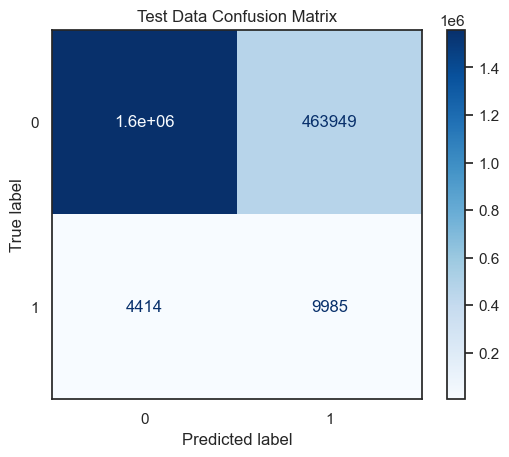

Test AUC-ROC: 0.80


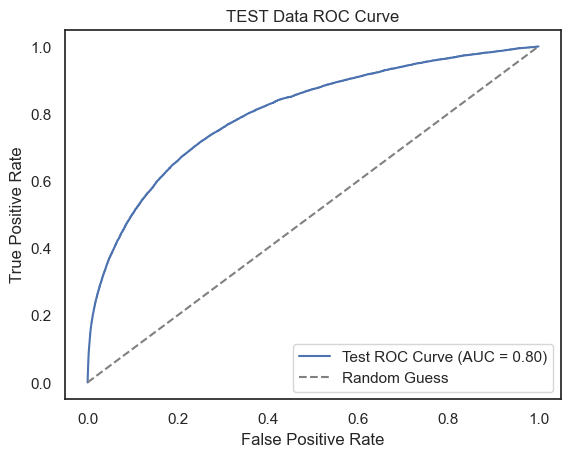

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

---

### 랜덤 포레스트 진행

In [31]:
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 랜덤 포레스트 모델
rf_model = RandomForestClassifier(
    n_estimators=100,  # 트리 개수
    random_state=42
)

# 모델 학습
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Test Accuracy: 0.81

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   2022707
           1       0.03      0.69      0.05     14399

    accuracy                           0.81   2037106
   macro avg       0.51      0.75      0.47   2037106
weighted avg       0.99      0.81      0.89   2037106


Confusion Matrix (테스트 데이터):
[[1635353  387354]
 [   4465    9934]]


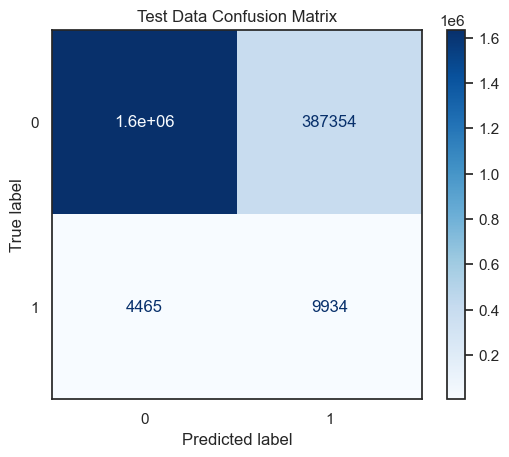

Test AUC-ROC: 0.82


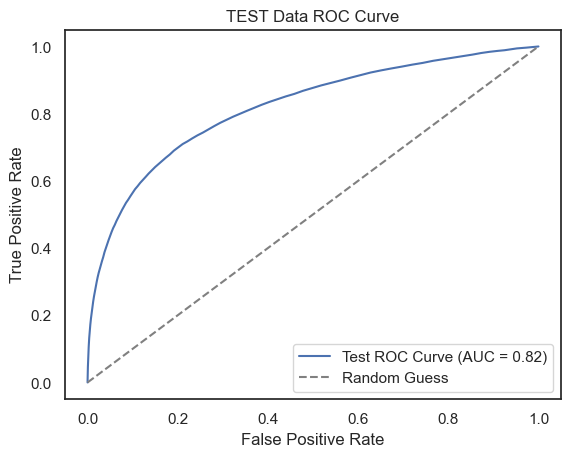

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = rf_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=rf_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

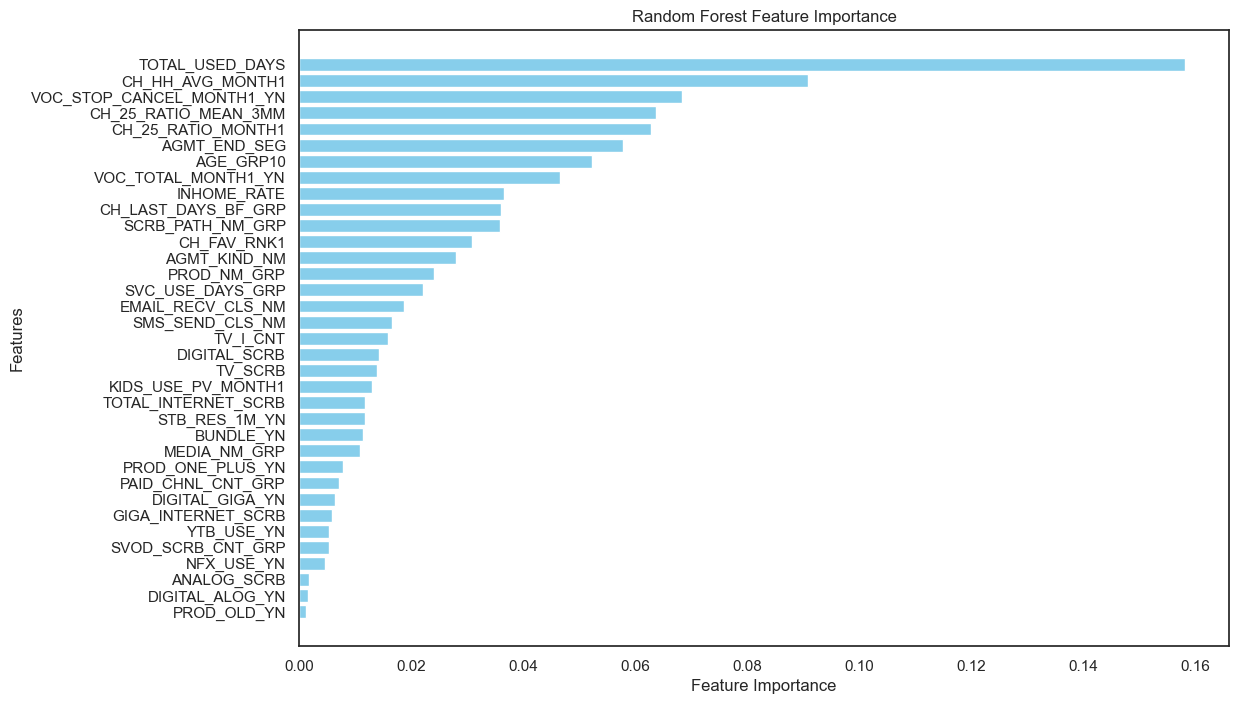

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### LGBM 진행

In [33]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Test Accuracy: 0.81

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   2022707
           1       0.03      0.74      0.05     14399

    accuracy                           0.81   2037106
   macro avg       0.51      0.77      0.47   2037106
weighted avg       0.99      0.81      0.89   2037106


Confusion Matrix (테스트 데이터):
[[1633716  388991]
 [   3798   10601]]


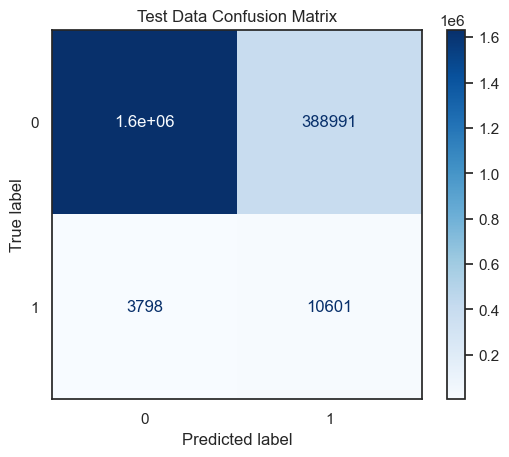

Test AUC-ROC: 0.85


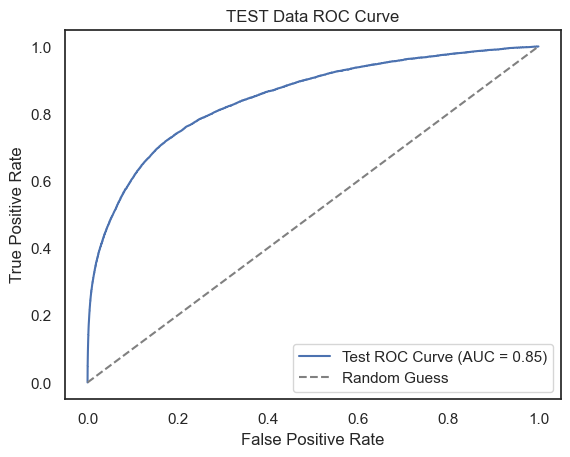

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

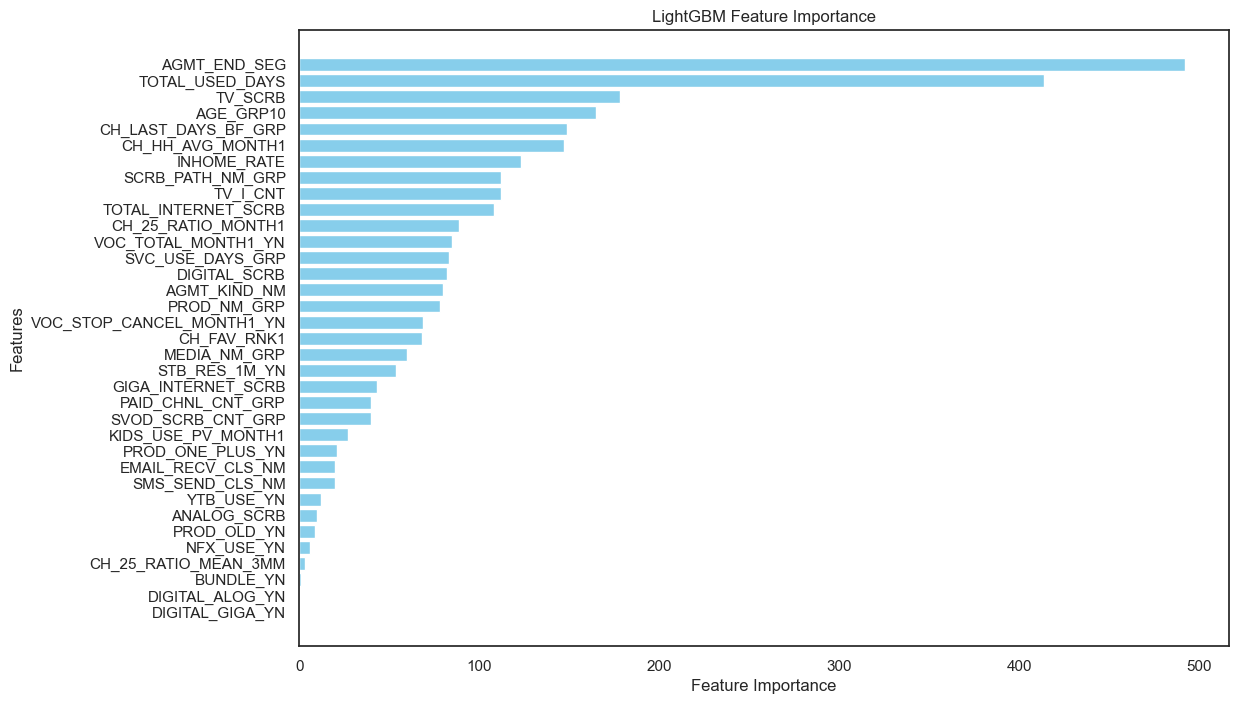

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### Catboost 진행

In [35]:
from catboost import CatBoostClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 기본값을 사용한 CatBoost 모델 생성
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

# 모델 학습
cat_model.fit(X_train, y_train)

0:	learn: 0.6825713	total: 226ms	remaining: 3m 45s
1:	learn: 0.6723641	total: 280ms	remaining: 2m 19s
2:	learn: 0.6628701	total: 309ms	remaining: 1m 42s
3:	learn: 0.6538149	total: 338ms	remaining: 1m 24s
4:	learn: 0.6454202	total: 366ms	remaining: 1m 12s
5:	learn: 0.6378533	total: 394ms	remaining: 1m 5s
6:	learn: 0.6309574	total: 422ms	remaining: 59.9s
7:	learn: 0.6242781	total: 456ms	remaining: 56.5s
8:	learn: 0.6177306	total: 526ms	remaining: 58s
9:	learn: 0.6118856	total: 628ms	remaining: 1m 2s
10:	learn: 0.6071300	total: 767ms	remaining: 1m 8s
11:	learn: 0.6025364	total: 808ms	remaining: 1m 6s
12:	learn: 0.5980415	total: 838ms	remaining: 1m 3s
13:	learn: 0.5937070	total: 869ms	remaining: 1m 1s
14:	learn: 0.5900499	total: 899ms	remaining: 59s
15:	learn: 0.5858110	total: 928ms	remaining: 57.1s
16:	learn: 0.5824597	total: 958ms	remaining: 55.4s
17:	learn: 0.5794634	total: 994ms	remaining: 54.2s
18:	learn: 0.5763114	total: 1.07s	remaining: 55.5s
19:	learn: 0.5726763	total: 1.15s	remain

Test Accuracy: 0.81

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   2022707
           1       0.03      0.74      0.05     14399

    accuracy                           0.81   2037106
   macro avg       0.51      0.77      0.47   2037106
weighted avg       0.99      0.81      0.89   2037106


Confusion Matrix (테스트 데이터):
[[1635546  387161]
 [   3771   10628]]


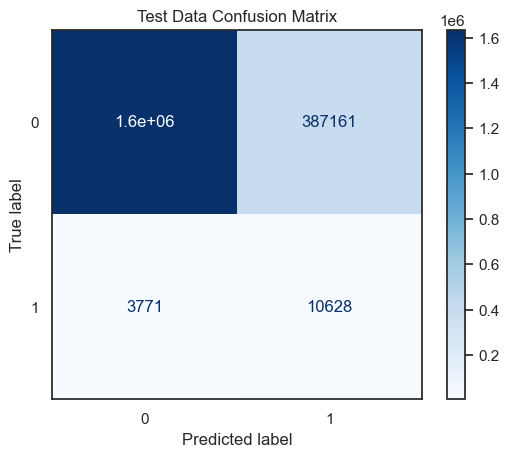

Test AUC-ROC: 0.85


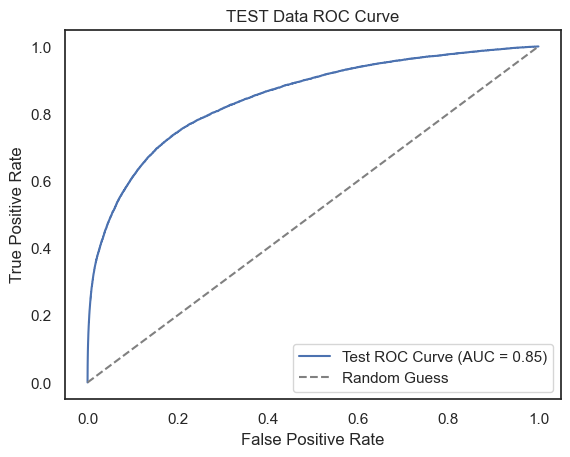

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = cat_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=cat_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = cat_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

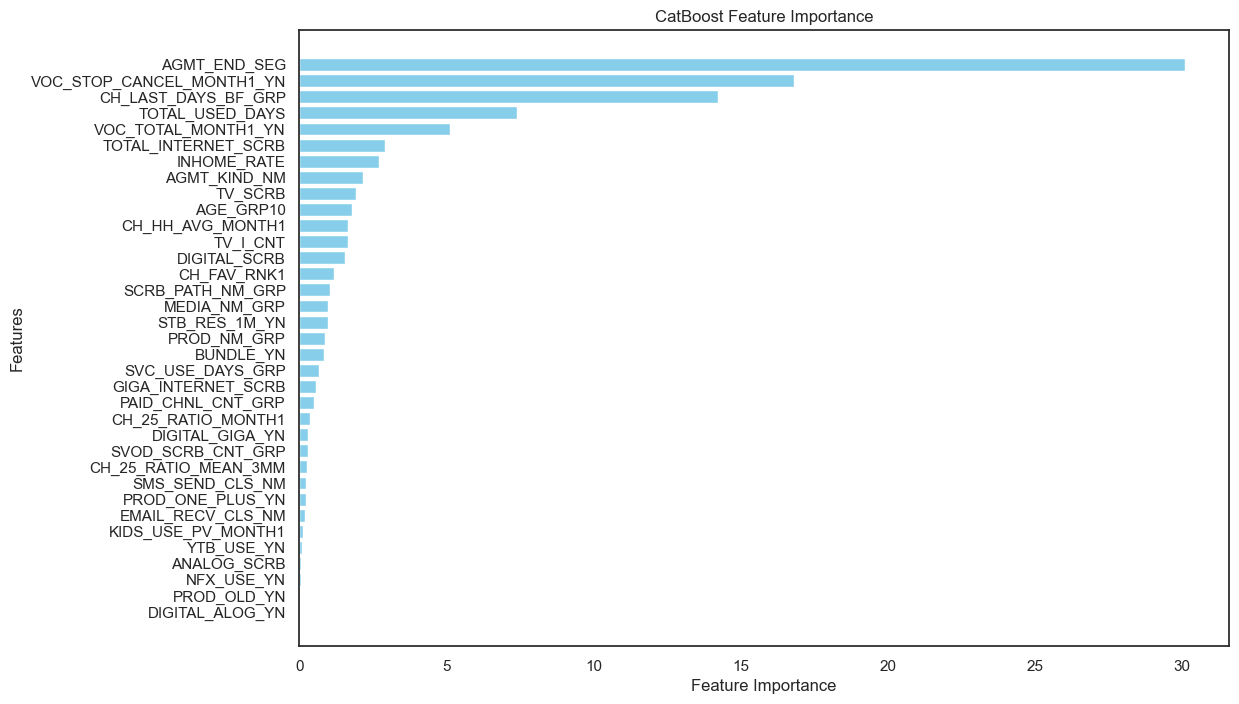

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()